In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
from tqdm import tqdm_notebook as tqdm

import torchvision
import torchvision.transforms as transforms

import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

Handle Data

In [5]:
valid_size = 0.2
batch_size = 32
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = torchvision.datasets.CIFAR10(
                root='../data', 
                train=True,
                download=True, 
                transform=transform)

test_data = torchvision.datasets.CIFAR10(
                root='../data', 
                train=False,
                download=True, 
                transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=2)

valid_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    sampler=valid_sampler, 
                    num_workers=2)

test_loader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=batch_size,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


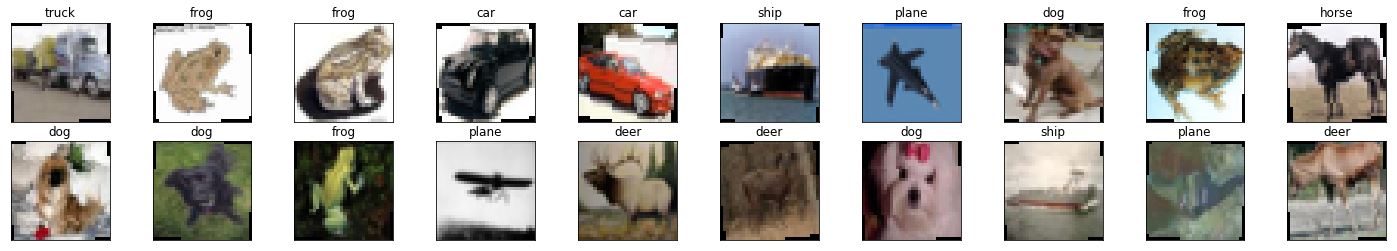

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

    # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Define models

In [7]:
from models import AlexNet

net = AlexNet(inputs=3, outputs = 10)

xent = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Train time

In [18]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

NB_EPOCHS = 1

for epoch in range(NB_EPOCHS):

    # train
    train_losses = []
    net.train()
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        output = net(data)
        loss = xent(output, target)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Train loss', loss.item(), batch_id)
        train_losses.append(loss.item())
        
    #evaluate model
    valid_losses = []
    net.eval()
    for data, target in valid_loader:
        output = net(data)
        loss = xent(output, target)
        valid_losses.append(loss.item())
    
    # calculate average losses
    train_loss = np.mean(train_losses)
    valid_loss = np.mean(valid_losses)

100%|██████████| 1250/1250 [03:47<00:00,  5.83it/s]


In [19]:
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 0 	Training Loss: 1.908426 	Validation Loss: 1.755264


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

100%|██████████| 313/313 [00:19<00:00, 16.93it/s]


In [21]:
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 39 %


Bayesian AlexNet

In [8]:
from bayes import Bayesian
from utils import ScaleMixtureGaussian, DEVICE, Var, PI, SIGMA_1, SIGMA_2


bayesnet = Bayesian(net, log_prior = 
                      ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2))


In [9]:
bayesnet

Bayesian(
  (0): BayesConv2D(weight_shape=(64, 3, 11, 11), bias_shape=(64,))
  (1): Softplus(beta=1, threshold=20)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BayesConv2D(weight_shape=(192, 64, 5, 5), bias_shape=(192,))
  (4): Softplus(beta=1, threshold=20)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): BayesConv2D(weight_shape=(384, 192, 3, 3), bias_shape=(384,))
  (7): Softplus(beta=1, threshold=20)
  (8): BayesConv2D(weight_shape=(256, 384, 3, 3), bias_shape=(256,))
  (9): Softplus(beta=1, threshold=20)
  (10): BayesConv2D(weight_shape=(128, 256, 3, 3), bias_shape=(128,))
  (11): Softplus(beta=1, threshold=20)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten()
  (14): BayesLinear(weight_shape=(10, 128), bias_shape=(10,))
)

In [10]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

NB_EPOCHS = 2
m = len(train_loader)

for epoch in range(NB_EPOCHS):

    # train
    net.train()
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        output = bayesnet(data)
        beta = 2 ** (m - (batch_id + 1)) / (2 ** m - 1)
        beta = 1/m
        kl, xe = beta*bayesnet.kl(), xent(output, target)
        loss = kl + xe
        writer.add_scalar('Train/kl', kl.item(), batch_id)
        writer.add_scalar('Train/xent', xe.item(), batch_id)
        writer.add_scalar('Train/loss', loss.item(), batch_id)
        
        loss.backward()
        optimizer.step()

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  Fi

KeyboardInterrupt: 

In [ ]:
      
    #evaluate model
    net.eval()
    for data, target in valid_loader:
        output = net(data)
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        kl, xe = beta*net.kl(), xent(output, target)
        writer.add_Scalar('Valid/KL', kl, batch_id)
        writer.add_Scalar('Valid/XENT', xent, batch_id)
        loss = kl + xe
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)